In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['image.cmap']='inferno'
import numpy as np
from scipy.stats import binned_statistic
matplotlib.rcParams['font.size']=12

In [2]:
# define a camera with coordinates (x,y) = alpha,beta inclined by 75 deg from the pole
nx=2048; ny=2048; rlim=3e4
a = np.arange(nx)/(nx-1.)*rlim-rlim/2.0; b = np.arange(ny)/(ny-1.)*3e4-rlim/2.0
alpha,beta = np.meshgrid(a,b)
i=75./180.*np.pi; cosi=np.cos(i); sini=np.sin(i)

# calculate radius and azimuth where rays sent from camera pixels intersect the "disk" in the equatorial plane
r=np.sqrt(beta**2./cosi**2.+alpha**2.); phi=np.arctan2(beta,alpha*cosi)
nu=1.+np.sqrt(1./2./r)*sini*np.cos(phi) #this is Doppler shift (check..? G = M = c = 1, but where does 2 come from?)
rmin=1e3 #just for fun

# ASK JASON TO DRAW A PICTURE OF GEOMETRY IN THIS CELL

In [3]:
def calc_A(A0,x,gamma):
    return A0*x**gamma

# THIS PHI IS WITH OBSERVER AT PHI=0!
# see Waters+2016

# this is the line of sight velocity gradient
def calc_dvldl(r,sini,phi,wind=1):
    if wind==1:
        phiterm=np.cos(phi)*(np.sqrt(2.)*np.cos(phi)+np.sin(phi)/2.)
    else:
        phiterm=np.cos(phi)*np.sin(phi)/2.
    dvl=3.*np.sqrt(1./2./r)/r*sini**2.*phiterm
    return dvl
# WHERE THE FUCK DOES THIS COME FROM? -- appendix to Waters idiot can you even read
def calc_dvldl_KIRK(r,sini,phi,windWeight=0):
    windPhi=np.cos(phi)*(np.sqrt(2.)*np.cos(phi)+np.sin(phi)/2.)
    diskPhi=phiterm=np.cos(phi)*np.sin(phi)/2.
    phiterm=windWeight*windPhi+(1-windWeight)*diskPhi
    dvl=3.*np.sqrt(1./2./r)/r*sini**2.*phiterm
    return dvl
#sqrt business is v_phi for circular gravitational symmetry
#should be sqrt(GM/r) so where does extra 1/sqrt(2) come from?

# this is the intensity in terms of the line optical depth tau and the line of sight velocity gradient
def intensity(A,r,dvldl,tau): #~dvldr
    return A/4./np.pi/r**2.*np.abs(dvldl)*(1.-np.exp(-tau))
#this is at least semi related to eqn 22 in Waters..? #check missing pieces and see if they are important?

In [4]:
# try a sample intensity calculation
gamma=1.; A0=1.; tau=10. #wtf is gamma and "A0"???
phin=phi+np.pi/2. #why + pi/2??? #because we're different than Chiang and Murray by 90 deg

# velocity gradient for wind and disk models (different forms of velocity gradients)
dvldlKIRK=calc_dvldl_KIRK(r,sini,phin,windWeight=1)
dvldl0KIRK=calc_dvldl_KIRK(r,sini,phin,windWeight=0)
dvldl=calc_dvldl(r,sini,phin,wind=1)
dvldl0=calc_dvldl(r,sini,phin,wind=0)
A=calc_A(A0,r,gamma)

# calculate intensities for the two cases
iab=intensity(A,r,dvldl,tau)
iab0=intensity(A,r,dvldl0,tau)
iabKIRK=intensity(A,r,dvldlKIRK,tau)
iab0KIRK=intensity(A,r,dvldl0KIRK,tau)
# set intensities inside of minimum radius = 0
iab[r < rmin]=0.
iab0[r < rmin]=0.
iabKIRK[r<rmin]=0.
iab0KIRK[r<rmin]=0.

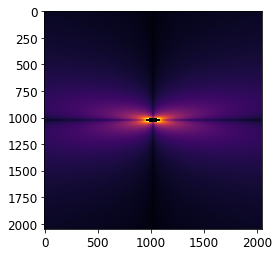

In [12]:
plt.imshow(iab0**(1/4)) #fx returns same result in limiting cases as Jason's does, just checking....

In [6]:
#TO-DO
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
#1. create "weight space" (range of weights for phiTerm) 
#2. iterate over weight space and generate plot frame at each one
#3. assemble into animation and show to Jason
import subprocess
def makeAnim(fileStruct,num0=3,fps=30,clean=True):
    subprocess.call(['ffmpeg -framerate {0} -i "{1}%0{2}d.png" -c:v libx264 -preset slow -coder 1 -movflags +faststart -g 15 -crf 18 -pix_fmt yuv420p -profile:v high -y -bf 2 "{1}.mp4"'.format(fps,fileStruct,num0)],shell=True)
    if clean==True:
        subprocess.call(['rm *.png'],shell=True) #clear frames
    
#1
wSpace=np.arange(0.01,1,0.01) #don't need zero or 1 because those limiting cases already done
#2
import pickle, sys
def load_pickle(file):
    with open(file, 'rb') as f:
        if sys.version_info.major > 2:
            data = pickle.load(f, encoding='latin1')
        else:
            data = pickle.load(f)
    return data
data = load_pickle('3c273_juljanmarmay_append_gilles_specirf_wide_v6.p')
lamcen=2.172


def genPlots(wSpace,data,lamcen):
        # define a camera with coordinates (x,y) = alpha,beta inclined by 75 deg from the pole
    nx=2048; ny=2048; rlim=3e4
    a = np.arange(nx)/(nx-1.)*rlim-rlim/2.0; b = np.arange(ny)/(ny-1.)*3e4-rlim/2.0
    alpha,beta = np.meshgrid(a,b)
    i=75./180.*np.pi; cosi=np.cos(i); sini=np.sin(i)

    # calculate radius and azimuth where rays sent from camera pixels intersect the "disk" in the equatorial plane
    r=np.sqrt(beta**2./cosi**2.+alpha**2.); phi=np.arctan2(beta,alpha*cosi)
    nu=1.+np.sqrt(1./2./r)*sini*np.cos(phi)
    rmin=1e3
    
    # try a sample intensity calculation
    gamma=1.; A0=1.; tau=10. #wtf is gamma and "A0"???
    phin=phi+np.pi/2. #why + pi/2??? #because we're different than Chiang and Murray by 90 deg
    
    vel=(data[0]-lamcen)/lamcen*3e5
    bins=100
    #get nu, iab
   
    dvldl0=calc_dvldl_KIRK(r,sini,phin,windWeight=0) #no wind limiting case
    dvldlWMax=calc_dvldl_KIRK(r,sini,phin,windWeight=1) #all wind limiting case
    A=calc_A(A0,r,gamma)
    iab0=intensity(A,r,dvldl0,tau)
    iabMax=intensity(A,r,dvldlWMax,tau)
    iabMax[r < rmin]=0.
    iab0[r < rmin]=0.
    spec0,edges0,n0=binned_statistic(nu.flatten(),iab0.flatten(),statistic='sum',bins=bins)
    specMax,edgesMax,nMax=binned_statistic(nu.flatten(),iabMax.flatten(),statistic='sum',bins=bins)
    nubin0=0.5*(edges0[1:]+edges0[:-1])
    N=1
    strLen=0
    
     # now what do the phases look like?
    u=[60.,45.,0.]; v=[0.,45.,60.]; blrang=3e8*2e33*6.67e-8/9e20/548./3.09e24
    #where do these numbers come from???
    x=alpha*blrang; y=beta*blrang; dphi0Max=[];
    
    fline0=spec0/np.max(spec0)*0.6/(1.+spec0/np.max(spec0)*0.6)
    flineMax=specMax/np.max(specMax)*0.6/(1.+specMax/np.max(specMax)*0.6)
    for i in range(len(u)):
        for ii in [iab0,iabMax]:
    #        dphi_map=-2.*np.pi*(x*u[i]+y*v[i])*ii*180./np.pi*1e6
    #        dphi_avg,p_edges,p_n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic='sum',bins=bins)
            dphi_avg=phase(nu,ii,x,y,u[i],v[i],bins=bins)
            dphi0Max.append(dphi_avg)
    for w in wSpace:
        dphi=[]
        string="{:.2f} % complete".format(N/len(wSpace)*100)
        sys.stdout.write("\r")
        sys.stdout.write(" "*strLen)
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
        strLen=len(string)
        dvldl=calc_dvldl_KIRK(r,sini,phin,windWeight=w)
        iab=intensity(A,r,dvldl,tau)
        iab[r<rmin]=0.
        spec,edges,n=binned_statistic(nu.flatten(), iab.flatten(), statistic='sum', bins=bins)
        nubin=0.5*(edges[1:]+edges[:-1])
        fig = plt.figure(1,figsize=(20,10))
        ax=plt.gca()
        plt.subplot(1,2,1)
        plt.errorbar(vel,data[3],data[6],marker='.',ms=10,ls='--',label='3C 273')
        plt.plot((nubin-1.)*3e5,spec/np.max(spec)*np.max(data[3]),label='weighted disk wind',lw=3,c='g')
        plt.plot((nubin0-1.)*3e5,spec0/np.max(spec0)*np.max(data[3]),label='no wind limit',lw=1,ls='--',c='r')
        plt.plot((nubin0-1.)*3e5,specMax/np.max(specMax)*np.max(data[3]),label='full wind limit',lw=1,ls='--',c='orange')
        plt.legend(loc='upper right')
        plt.axis([-5000,5000,0,0.65])
        plt.ylabel('flux')
        plt.xlabel('velocity (km/s)')
        #plt.subplots_adjust(left=0.18,right=0.98,bottom=0.15,top=0.98)
        
        plt.subplot(1,2,2)
   
        fline=spec/np.max(spec)*0.6/(1.+spec/np.max(spec)*0.6)
        for i in range(len(u)):
            for ii in [iab]:
        #        dphi_map=-2.*np.pi*(x*u[i]+y*v[i])*ii*180./np.pi*1e6
        #        dphi_avg,p_edges,p_n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic='sum',bins=bins)
                dphi_avg=phase(nu,ii,x,y,u[i],v[i],bins=bins)
                dphi.append(dphi_avg)
        # wind model shows a strong disk-like phase
        rfac=1.3 #need to do this for all cases..? where come from? see bottom cell
        plt.plot((nubin-1.)*3e5,dphi[0]*fline*rfac,label='weighted disk wind',lw=3,c='g')
        plt.plot((nubin-1.)*3e5,dphi0Max[0]*fline0*rfac,label='no wind limit',lw=1,ls='--',c='r')
        plt.plot((nubin-1.)*3e5,dphi0Max[1]*flineMax*rfac,label="full wind limit",lw=1,ls='--',c='orange')
        indx=[0,1,2,6,7,8,12,13,14,18,19,20]; oindx=[3,4,5,9,10,11,15,16,17,21,22,23] #what's this for?
        plt.errorbar(vel,np.mean(data[4][indx],axis=0),vel*0.+0.07,marker='.',ms=10,ls='--',label='3C 273')
        #plt.plot((nubin-1.)*3e5,dphi[2])
        #/np.sum(spec0)*np.sum(spec))
        plt.legend(loc='upper right')
        plt.axis([-7000,7000,np.min(dphi0Max[0]*fline0)*1.1,np.max(dphi0Max[0]*fline0)*1.1])
        plt.xlabel('velocity (km/s)'); plt.ylabel('phase (deg)')
        
        fig.suptitle("Wind weight = {:.2f}".format(w))
        fig.savefig('CM96_WindDiskWeighted_frame%03d.png' %N,bbox_layout='tight',pad_inches=0,dpi=300)
        plt.close()
        N+=1

genPlots(wSpace,data,lamcen)

NameError: name 'phase' is not defined

In [ ]:
makeAnim('CM96_WindDiskWeighted_frame',fps=5)

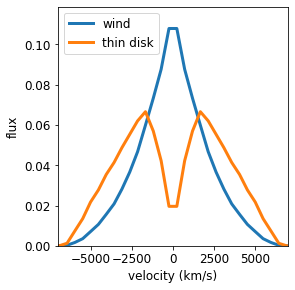

In [13]:
# make plots of the line profiles flux vs. velocity (wavelength) for the two cases
# the "disk" case is double-peaked as expected, while the wind has most of the emission 
# close to zero velocity and hides the double peaks.
# this is the main result of Chiang & Murray 1996 -- even at high inclination, wind emission lines can be single peaked

bins=100
spec,edges,n=binned_statistic(nu.flatten(), iab.flatten(), statistic='sum', bins=bins)
nubin=0.5*(edges[1:]+edges[:-1])
spec0,edges0,n0=binned_statistic(nu.flatten(), iab0KIRK.flatten(), statistic='sum', bins=bins)
plt.figure(figsize=(4,4))
plt.plot((nubin-1.)*3e5,spec/np.sum(spec),label='wind',linewidth=3)
plt.plot((nubin-1.)*3e5,spec0/np.sum(spec0),label='thin disk',linewidth=3)
plt.legend(loc='upper left')
plt.axis([-7000,7000,0,np.max(spec/np.sum(spec))*1.1])
plt.ylabel('flux')
plt.xlabel('velocity (km/s)')
fline=spec/np.max(spec)*0.6/(1.+spec/np.max(spec)*0.6)
fline0=spec0/np.max(spec0)*0.6/(1.+spec0/np.max(spec0)*0.6)
plt.subplots_adjust(left=0.18,right=0.98,bottom=0.15,top=0.98)
#plt.savefig('CM96_W16_wind_disk_line_profile.pdf',bbox_layout='tight',pad_inches=0)

In [17]:
def centroid(nu,iab,alpha,beta,bins=100):
    xcen,edges,n = binned_statistic(nu.flatten(),iab.flatten()*alpha.flatten(),statistic='sum',bins=bins)
    ycen,edges,n = binned_statistic(nu.flatten(),iab.flatten()*beta.flatten(),statistic='sum',bins=bins)
    isum,edges,n = binned_statistic(nu.flatten(),iab.flatten(),statistic='sum',bins=bins)
    isum[isum==0.]=1.
    return xcen/isum, ycen/isum #xcen and ycen means alpha and beta

def phase(nu,iab,x,y,u,v,bins=100):
    dphi_map=-2.*np.pi*(x*u+y*v)*iab*180./np.pi*1e6 #this seems similar to eqn 6 in gravity but not really?
    #1e6 in units of u and v, 180/pi to convert rad to deg
    #also what is ii...???? oh I see declared in loop below but bad practice to not pass as param
    dphi,edges,n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic='sum',bins=bins)
    isum,edges,n = binned_statistic(nu.flatten(),iab.flatten(),statistic='sum',bins=bins)
    isum[isum==0.]=1. #why?
    return dphi/isum

In [18]:
# now what do the phases look like?
u=[60.,45.,0.]; v=[0.,45.,60.]; blrang=3e8*2e33*6.67e-8/9e20/548./3.09e24 #u and v are telescope baselines measured in units of lambda
#different orientations are in u and v; blrang assigns size on sky of source in waters
#where do these numbers come from???
x=alpha*blrang; y=beta*blrang; dphi=[] #alpha and beta originally in units of R_s (?) and now in units of angular position
for i in range(len(u)):
    for ii in [iab,iab0]:
#        dphi_map=-2.*np.pi*(x*u[i]+y*v[i])*ii*180./np.pi*1e6
#        dphi_avg,p_edges,p_n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic='sum',bins=bins)
        dphi_avg=phase(nu,ii,x,y,u[i],v[i],bins=bins)
        dphi.append(dphi_avg)

In [21]:
len(dphi[0])

100

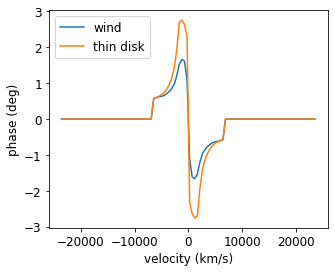

In [29]:
# wind model shows a strong disk-like phase 
# this is wrong! ? why only plot 0, 1 when dphi has six things 
# 0,1 is a pair at one baseline, 2,3 is a pair at second baseline, etc
plt.figure(figsize=(5,4))
plt.plot((nubin-1.)*3e5,dphi[0]*fline,label='wind')
#plt.plot((nubin-1.)*3e5,dphi[2])
plt.plot((nubin-1.)*3e5,dphi[1]*fline0,label='thin disk')#/np.sum(spec0)*np.sum(spec),label='disk')
#/np.sum(spec0)*np.sum(spec))
plt.legend(loc='upper left')
plt.axis([-7000,7000,np.min(dphi[1]*fline0)*1.1,np.max(dphi[1]*fline0)*1.1])
plt.xlabel('velocity (km/s)'); plt.ylabel('phase (deg)')
plt.savefig('CM96_W16_wind_disk_phases.pdf',bbox_layout='tight',pad_inches=0)

In [ ]:
xcen,ycen = centroid(nu,iab,alpha,beta,bins=bins)
xcen0,ycen0 = centroid(nu,iab0,alpha,beta,bins=bins)

In [ ]:
# centroids are only a little different for wind and rotation!
lim=20000.*blrang/4.85e-12 #again...where??? why???`
plt.figure(figsize=(5,4))
plt.plot(xcen[15:-15]*blrang/4.85e-12,ycen[15:-15]*blrang/4.85e-12,marker='o',label='wind',zorder=1)
plt.plot(xcen0[15:-15]*blrang/4.85e-12,ycen0[15:-15]*blrang/4.85e-12,marker='o',label='thin disk',zorder=0)
plt.axis([-lim,lim,-lim,lim])
plt.xlabel('x ($\mu$as)'); plt.ylabel('y ($\mu$as)')
plt.axes().set_aspect('equal')
plt.legend(loc='upper left')
plt.savefig('CM96_W16_wind_disk_centroids.pdf',bbox_layout='tight',pad_inches=0)

In [ ]:
# with data
import pickle, sys
def load_pickle(file):
    with open(file, 'rb') as f:
        if sys.version_info.major > 2:
            data = pickle.load(f, encoding='latin1')
        else:
            data = pickle.load(f)
    return data
data = load_pickle('3c273_juljanmarmay_append_gilles_specirf_wide_v6.p')
lamcen=2.172
vel=(data[0]-lamcen)/lamcen*3e5

In [ ]:
# that is quite reasonable from a first guess!
fig,ax = plt.subplots(1,figsize=(10,10))
plt.errorbar(vel,data[3],data[6],marker='.',ms=10,ls='--',label='3C 273')
plt.plot((nubin-1.)*3e5,spec/np.max(spec)*np.max(data[3]),label='disk wind',linewidth=3)
labels, handles = ax.get_legend_handles_labels()
plt.legend(labels[::-1],handles[::-1],loc='upper right')
plt.axis([-5000,5000,0,0.65])
plt.ylabel('flux')
plt.xlabel('velocity (km/s)')
plt.subplots_adjust(left=0.18,right=0.98,bottom=0.15,top=0.98)
plt.savefig('CM96_W16_wind_3c273_spectra.pdf',bbox_layout='tight',pad_inches=0)

In [ ]:
# now what do the phases look like?
from scipy.ndimage import gaussian_filter1d
u=data[1]; v=data[2]; blrang=3e8*2e33*6.67e-8/9e20/548./3.09e24
x=alpha*blrang; y=beta*blrang; dphi=[]; psf=4e-3/2.35
for i in range(len(u)):
    for ii in [iab]:
#        dphi_map=-2.*np.pi*(x*u[i]+y*v[i])*ii*180./np.pi*1e6
#        dphi_avg,p_edges,p_n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic='sum',bins=bins)
        dphi_avg_raw=phase(nu,ii,x,y,u[i],v[i],bins=bins)
        dphi_avg = gaussian_filter1d(dphi_avg_raw,psf/3e5/(nubin[1]-nubin[0])) #WHAT IS PSF??? This doesn't work as is, only using "raw" implementation in master plot cell
        dphi.append(dphi_avg)

In [ ]:
# radius factor chosen for best match to data; also means M_BH goes up by that factor
rfac=1.3
indx=[0,1,2,6,7,8,12,13,14,18,19,20]; oindx=[3,4,5,9,10,11,15,16,17,21,22,23] #what's this for?
fig,ax = plt.subplots(1,figsize=(4,4))
plt.errorbar(vel,np.mean(data[4][indx],axis=0),vel*0.+0.07,marker='o',label='3C 273') #why *0+0.07
plt.plot((nubin-1.)*3e5,np.mean(np.array(dphi)[indx],axis=0)*fline*rfac,linewidth=3,label='disk wind') #why do we also need idx here?
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],loc='upper left')
#plt.plot((nubin-1.)*3e5,np.mean(np.array(dphi)[oindx],axis=0)*fline*rfac,linewidth=3)
plt.axis([-5000,5000,-0.35,0.35])
plt.xlabel('velocity (km/s)'); plt.ylabel('phase (deg)')
plt.subplots_adjust(left=0.18,right=0.98,bottom=0.15,top=0.98)
plt.savefig('CM96_W16_wind_3c273_phases.pdf',bbox_layout='tight',pad_inches=0)